<h1><center><font color=DarkSlateBlue   >Grad Independent Study Project - IMDB Review Classification</center></h1> <font color>
    Student - Vaseem Khan <br/>
    Instructor - Dr. Genc


**Executive Summary** <br>
***
<font color=SlateGray>The primary objective of the project was to explore the possibility of using written words as identifier of reviewer expertise. The scope of the project was restricted to to analyzing reviews written on IMDB website and utilizing multiple Machine learning models to predict whether the review was written by ***<u>Layman</u>*** or an ***<u>Expert</u>***. <br> 
    In the first part of project we made an hypothesis 'The Expert user review will showcase use of wide ranging vocabulary compared to a Normal user'. To test this hypothesis we rectified the data imbalance issue and truncated text to 500 characters. Thereafter we vectorized our dataset and ran 3 Machine Learning models (<i><u>SVM,Random Forest and Logistic Regression</i></u>) however our results were close to 55% accuracy which is just better than a random guess. <br>
    We then forward with a new hypothesis that 'The Expert user may have a different composition % of use of Part of Speech like 'Noun','Verb','Adjective' etc compared to a Normal user'. To test this hypotheis we utilized entire review text and the same 3 models and got much improved results ranging upto 88% accuracy. <br>
    To further check the possibility of improving accuracy we combined the Vectorized data and the POS Tag data and ran the ML models 
    
This entire exercise was accomplished using different Python's libraries like Scikit Learn, NLTK, Pandas and Numpy
    
The concept of utizing reviews to identify 'User Expertise/Non Expertise' has wide ranging business application. One of the examples would by any eCommerce website like Amazon can utilize utilize the model to identify quality reviewer with ML models and target them with free samples for additional quality reviews of listed products.

<h2><center><font color=DarkSlateBlue>Loading Python Packages Preprocessing data

In [31]:
#Loading Base Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Loading Scikit Learn Machine Learning and PreprocessingPackages
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

#Data Split and Cross Validations
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score

#Loading NLTK Library for Textual Analysis and Processing
import nltk
from nltk import Counter
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
sw = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()


#Loading Packages for Metrics and Accuracy Checks
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score


<h4><left><font color=DarkSlateBlue>     Loading Files,Slicing Data and Renaming Columns

In [32]:
#Reading Data from CSV file using Pandas
critic_data = pd.read_csv('C:/Data Science/Independent Project/expert_reviews.csv')
user_data = pd.read_csv('C:/Data Science/Independent Project/Consolidate.csv',encoding='latin1')

#Slicing Required columns
ud = user_data[['links_link','links_product_review']]
cd = critic_data[['clean url','review text']]

#Renaming Columns
ud.columns = ['Links','Review']
cd.columns = ['Links','Review']
print('Total Normal Reviews: ',len(ud))
print('Total Expert Reviews: ',len(cd))

Total Normal Reviews:  88233
Total Expert Reviews:  19047


<h4><left><font color=DarkSlateBlue> Dropping NA,creating copy and checking row count

In [33]:
#Dropping NA,creating copy and checking row count

ud = ud.dropna(axis=0,how='any').copy()
cd = cd.dropna(axis=0,how='any').copy()
print('Total Normal Reviews after dropping NAs:',len(ud))
print('Total Expert Reviews after dropping NAs:',len(cd))

Total Normal Reviews after dropping NAs: 72487
Total Expert Reviews after dropping NAs: 18628


<h4><left><font color=DarkSlateBlue> Data is imbalanced and we will randomly sample 15K rows from each dataset

In [34]:
ud = ud.sample(n=15000,random_state=100)
cd = cd.sample(n=15000,random_state=100)
print('Normal User Sample utilized: ',len(ud))
print('Expert User Review Utilized: ',len(cd))

Normal User Sample utilized:  15000
Expert User Review Utilized:  15000


In [35]:
#Adding new column labes for each dataset and combining them. Adding new rows of labels

ud['Reviewer'] = 'Normal'
cd['Reviewer'] = 'Expert'
combine = pd.concat([ud,cd],ignore_index=True)
review = combine['Review']
label = combine['Reviewer']

<h2><left><font color=DarkSlateBlue> Note </h2>

    
<font color=SlateGray> We ran our model using entire text from each review earlier. This provides us a unusally a very high accuracy in our model. The primary cause of this was length of reviews. Experts on an average tends to write longer reviews(5000+ character) compared to normal reviewer (~600 character). Hence to remove that differentiating factor we decided to utilize only first 500 characters of the review.  <font color=SlateGray> <br>
    ** Below table and graphs shows our stated observation **

In [36]:
# Checking Mean length of reviewer before Truncation
combine['Text length'] = combine['Review'].apply(lambda x: len(x))
combine.groupby(['Reviewer']).mean().round(0)

,Text length
Reviewer,
Expert,5083.0
Normal,585.0


C:\Users\vasee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


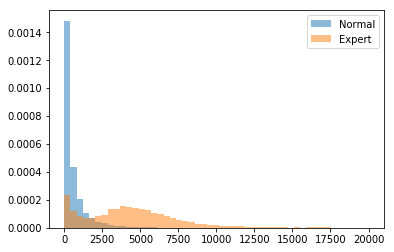

In [37]:
#Plotting Graph to show above observation
bins = np.linspace(0,20000,num = 50)
plt.hist(combine[combine['Reviewer']=='Normal']['Text length'],bins,alpha = 0.5,normed=True,label='Normal')
plt.hist(combine[combine['Reviewer']=='Expert']['Text length'],bins,alpha = 0.5,normed=True,label='Expert')
plt.legend(loc='upper right')
plt.show()

In [38]:
#Truncating Review size to 500 characters

combine['Review_Short'] = combine['Review'].str[:500]

<h2><center><font color=DarkSlateBlue>Text Cleanup and Vectorization
    
    

<font color=SlateGray> After truncating the review we are defining a function to conduct the following preprocessing on our review:
    - remove punctuations
    - Lower the case
    - Split the text with regex
    - Stem the words using Porter stemming
 This will help to create a matrix which will be utilized as input to  run our Machine Learning 
 
    The ** Porter stemming algorithm (or ‘Porter stemmer’)** is a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a term normalisation process that is usually done when setting up Information Retrieval systems.
    
    ** Count Vectorizer ** convert a collection of text documents to a matrix of token counts

In [39]:
# Writing function to remove punc and stopwords,split and stem them) 

def clean_text(text):
    text = "".join([i.lower() for i in text if i not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [ps.stem(i) for i in tokens if i not in sw]
    return text
combine['ouput'] = combine['Review_Short'].apply(lambda x: clean_text(x))

In [40]:
#Running Clean_text function and vectorizing data using Count Vectorizer

count_vect = CountVectorizer(analyzer=clean_text)
X_tfid = count_vect.fit_transform(combine['ouput'])


<h2><center><font color=DarkSlateBlue>Machine Learning</center></h2> <font color> 

<h3><center><font color=DarkSlateBlue >Random Forest (Count Vect)</center></h3> <font color> 
    <font color=SlateGray>A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement 
   

In [41]:
#Creating Training and Testing Samples
X_train, y_train, X_test,y_test = train_test_split(X_tfid,label,test_size = 0.2,random_state=52)

# Running KFold cross validaton

rf = RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=20)
k_fold = KFold(n_splits=5)
cross_val_score(rf,X_train,X_test,cv=k_fold,scoring='accuracy',n_jobs=-1)

array([0.55      , 0.54895833, 0.543125  , 0.48208333, 0.555625  ])

<h5><left><font color=DarkSlateBlue >Our model accuracy is very low and close to random guessing, we will continue to run other models

In [42]:
#Running Random forest model
rf = RandomForestClassifier(n_estimators=100,max_depth=20,n_jobs=-1)
rf_model = rf.fit(X_train,X_test)
y_pred =rf_model.predict(y_train)

# Review Results
results=pd.DataFrame(list(zip(y_pred, y_test)),columns=['Predictions','Actual'])
print(results.groupby(['Actual','Predictions'])['Actual'].agg('count'))

print()

precision, recall,fscore,support = score(y_test,y_pred,pos_label='Expert',average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round((y_pred==y_test).sum()/len(y_pred),3)))

Actual  Predictions
Expert  Expert          288
        Normal         2728
Normal  Normal         2984
Name: Actual, dtype: int64

Precision: 1.0 / Recall: 0.095 / Accuracy: 0.545


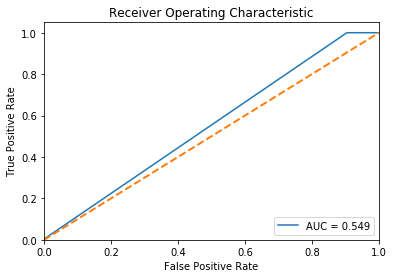

In [43]:
#Preparing ROC Curve for Random Forest

y_test.replace('Expert',1,inplace=True)
y_test.replace('Normal',0,inplace=True)
y_pred = pd.Series(y_pred)
y_pred.replace('Expert',1,inplace=True)
y_pred.replace('Normal',0,inplace=True)

# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(y_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(tpr, fpr)

# method I: plt
lw = 2
plt.title('Receiver Operating Characteristic')
plt.plot(tpr, fpr,label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h3><center><font color=DarkSlateBlue >Support Vector Machine (Count Vect)</center></h3> <font color> <br>
   <font color=SlateGray> A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

In [44]:
X_train, y_train, X_test,y_test = train_test_split(X_tfid,label,test_size = 0.2,random_state=52)
svm = SVC(kernel='linear',probability=True)
svm_model = svm.fit(X_train,X_test)
y_pred = svm_model.predict(y_train)

In [45]:
from sklearn.model_selection import KFold,cross_val_score
svm = SVC(kernel='linear')
k_fold = KFold(n_splits=5)
cross_val_score(svm,X_train,X_test,cv=k_fold,scoring='accuracy',n_jobs=-1)

array([0.56645833, 0.563125  , 0.55875   , 0.58229167, 0.57166667])

In [46]:
#Review Results
results=pd.DataFrame(list(zip(y_pred, y_test)),columns=['Predictions','Actual'])
print(results.groupby(['Actual','Predictions'])['Actual'].agg('count'))

print()

precision, recall,fscore,support = score(y_test,y_pred,pos_label='Expert',average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round((y_pred==y_test).sum()/len(y_pred),3)))

Actual  Predictions
Expert  Expert          370
        Normal         2646
Normal  Normal         2984
Name: Actual, dtype: int64

Precision: 1.0 / Recall: 0.123 / Accuracy: 0.559



<h3><center><font color=DarkSlateBlue >Logistic Regression (Count Vect)</center></h3> <font color> <br>
      <font color=SlateGray>  Logistic regression is a classification algorithm used to assign observations to a discrete set of classes. Unlike linear regression which outputs continuous number values, logistic regression transforms its output using the logistic sigmoid function to return a probability value which can then be mapped to two or more discrete classes.
    
 

In [47]:
#Creating Training and Testing Samples
X_train, y_train, X_test,y_test = train_test_split(X_tfid,label,test_size = 0.2,random_state=52)
logr = LogisticRegression()
logr_model = logr.fit(X_train,X_test)
y_pred = logr.predict(y_train)

In [48]:
#Review Results
results=pd.DataFrame(list(zip(y_pred, y_test)),columns=['Predictions','Actual'])
print(results.groupby(['Actual','Predictions'])['Actual'].agg('count'))

print()

precision, recall,fscore,support = score(y_test,y_pred,pos_label='Expert',average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round((y_pred==y_test).sum()/len(y_pred),3)))

Actual  Predictions
Expert  Expert          370
        Normal         2646
Normal  Normal         2984
Name: Actual, dtype: int64

Precision: 1.0 / Recall: 0.123 / Accuracy: 0.559


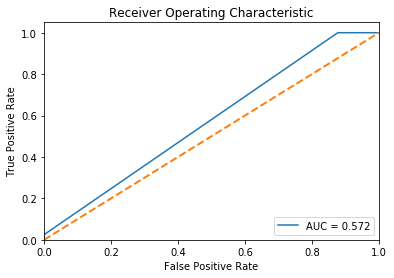

In [49]:
#Preparing ROC Curve for Logistic Regression

y_test.replace('Expert',1,inplace=True)
y_test.replace('Normal',0,inplace=True)
y_pred = pd.Series(y_pred)
y_pred.replace('Expert',1,inplace=True)
y_pred.replace('Normal',0,inplace=True)

# calculate the fpr and tpr for all thresholds of the classification
probs = logr.predict_proba(y_train)
preds3 = probs[:,1]
fpr3, tpr3, threshold = metrics.roc_curve(y_test, preds3)
roc_auc3 = metrics.auc(tpr3, fpr3)

# method I: plt
lw = 2
plt.title('Receiver Operating Characteristic')
plt.plot(tpr3, fpr3,label = 'AUC = %0.3f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h2><center><font color=DarkSlateBlue >Note </center></h2> <font color> 
    <left><font color=DarkSlateBlue >Based on the results of our 3 models we can say the use of Count Vectorizer(word frequency) is not sufficient to classify user reviews. There seems to no strong differentiating factors among word frequency count. Hence we will move to utilize NLTK Part of Speech tags to check if they can help to classify our reviewers

<h2><center><font color=DarkSlateBlue >Prediction using Part of Speech Tagging</center></h2> <font color>
       <font color=SlateGray> We are using NLTK library to identify word's Part of Speech and will then generate a counter to see frequency of a particular POS in % terms compared to total word count.Also unlike above model we will use entire text and not truncated text for analysis.

In [50]:
#Removing Punctuation from Original Review
def clean_text(text):
    text = "".join([i.lower() for i in text if i not in string.punctuation])
    return text
combine['Review_without_punc'] = combine['Review'].apply(lambda x: clean_text(x))

In [51]:
###Very Time Consuming Operation - Since its utilized complete Review Text(Non Truncated)
#Tokenize, create Part of Speech Tags and combine them

combine['pos text'] =  [nltk.word_tokenize(i)for i in combine['Review_without_punc']] 
combine['pos'] =  [nltk.pos_tag(i)for i in combine['pos text']]   
combine['pos_counter'] = [Counter( tag for word ,  tag in i) for i in combine['pos']] 

In [74]:
#Getting count columns  for  each Part of Speech Tag
pos_councter_df = combine['pos_counter'].apply(pd.Series)
pos_councter_df = pos_councter_df.fillna(0)

In [55]:
pos_councter_df.columns.tolist()

['NNS',
 'VBP',
 'PRP',
 'DT',
 'NN',
 'RB',
 'VBZ',
 'IN',
 'JJ',
 'WRB',
 'PRP$',
 'CC',
 'CD',
 'MD',
 'VB',
 'TO',
 'VBG',
 'JJS',
 'VBD',
 'VBN',
 'WP',
 'RBR',
 'JJR',
 'WDT',
 'EX',
 'RP',
 'PDT',
 'RBS',
 'FW',
 'NNPS',
 'UH',
 'NNP',
 'WP$',
 '$',
 "''",
 'POS',
 'SYM']

In [56]:
# To get complete info on various NLTK tagset we can run below command
#nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [75]:
#Dropping columns with $ amount
pos_councter_df = pos_councter_df.drop([ "''", '$'],axis=1)
#nltk.help.upenn_tagset()

In [76]:
#Calcuating a new column to find total number of words in the sentence
pos_councter_df['WC'] = pos_councter_df.sum(axis=1)

#Calculating % of each POS in total word Count
pos_councter_df['NNS'] = pos_councter_df['NNS']/pos_councter_df['WC']
pos_councter_df[ 'VBP'] = pos_councter_df[ 'VBP']/pos_councter_df['WC']
pos_councter_df[ 'PRP'] = pos_councter_df[ 'PRP']/pos_councter_df['WC']
pos_councter_df[ 'DT'] = pos_councter_df[ 'DT']/pos_councter_df['WC']
pos_councter_df[ 'NN'] = pos_councter_df[ 'NN']/pos_councter_df['WC']
pos_councter_df[ 'RB'] = pos_councter_df[ 'RB']/pos_councter_df['WC']
pos_councter_df[ 'VBZ'] = pos_councter_df[ 'VBZ']/pos_councter_df['WC']
pos_councter_df[ 'IN'] = pos_councter_df[ 'IN']/pos_councter_df['WC']
pos_councter_df[ 'JJ'] = pos_councter_df[ 'JJ']/pos_councter_df['WC']
pos_councter_df[ 'WRB'] = pos_councter_df[ 'WRB']/pos_councter_df['WC']
pos_councter_df[ 'PRP$'] = pos_councter_df[ 'PRP$']/pos_councter_df['WC']
pos_councter_df[ 'CC'] = pos_councter_df[ 'CC']/pos_councter_df['WC']
pos_councter_df[ 'CD'] = pos_councter_df[ 'CD']/pos_councter_df['WC']
pos_councter_df[ 'MD'] = pos_councter_df[ 'MD']/pos_councter_df['WC']
pos_councter_df[ 'VB'] = pos_councter_df[ 'VB']/pos_councter_df['WC']
pos_councter_df[ 'TO'] = pos_councter_df[ 'TO']/pos_councter_df['WC']
pos_councter_df[ 'VBG'] = pos_councter_df[ 'VBG']/pos_councter_df['WC']
pos_councter_df[ 'JJS'] = pos_councter_df[ 'JJS']/pos_councter_df['WC']
pos_councter_df[ 'VBD'] = pos_councter_df[ 'VBD']/pos_councter_df['WC']
pos_councter_df[ 'VBN'] = pos_councter_df[ 'VBN']/pos_councter_df['WC']
pos_councter_df[ 'WP'] = pos_councter_df[ 'WP']/pos_councter_df['WC']
pos_councter_df[ 'RBR'] = pos_councter_df[ 'RBR']/pos_councter_df['WC']
pos_councter_df[ 'JJR'] = pos_councter_df[ 'JJR']/pos_councter_df['WC']
pos_councter_df[ 'WDT'] = pos_councter_df[ 'WDT']/pos_councter_df['WC']
pos_councter_df[ 'EX'] = pos_councter_df[ 'EX']/pos_councter_df['WC']
pos_councter_df[ 'RP'] = pos_councter_df[ 'RP']/pos_councter_df['WC']
pos_councter_df[ 'PDT'] = pos_councter_df[ 'PDT']/pos_councter_df['WC']
pos_councter_df[ 'RBS'] = pos_councter_df[ 'RBS']/pos_councter_df['WC']
pos_councter_df[ 'FW'] = pos_councter_df[ 'FW']/pos_councter_df['WC']
pos_councter_df[ 'NNPS'] = pos_councter_df[ 'NNPS']/pos_councter_df['WC']
pos_councter_df[ 'UH'] = pos_councter_df[ 'UH']/pos_councter_df['WC']
pos_councter_df[ 'NNP'] = pos_councter_df[ 'NNP']/pos_councter_df['WC']
pos_councter_df[ 'WP$'] = pos_councter_df[ 'WP$']/pos_councter_df['WC']
pos_councter_df[ 'POS'] = pos_councter_df[ 'POS']/pos_councter_df['WC']
pos_councter_df[ 'SYM'] = pos_councter_df[ 'SYM']/pos_councter_df['WC']
#pos_councter_df[ 'WC'] = pos_councter_df[ 'WC']/pos_councter_df['WC']



#Filling NAN with 0
pos_councter_df = pos_councter_df.fillna(0)


In [77]:
#Combining and labelling dataset
combine_new = pd.concat([combine['Reviewer'], pos_councter_df], axis=1)
feature = combine_new.iloc[:,1:-1]
label = combine_new['Reviewer']


<h3><center><font color=DarkSlateBlue >Support Vector Machine (POS Tags)</center></h3> 

In [78]:
X_train, y_train, X_test,y_test = train_test_split(feature,label,test_size = 0.2,random_state=52)
svm = SVC(kernel='linear',probability=True)
svm_model = svm.fit(X_train,X_test)
y_pred2 = svm_model.predict(y_train)

In [79]:
#Review Results
results=pd.DataFrame(list(zip(y_pred, y_test)),columns=['Predictions','Actual'])
print(results.groupby(['Actual','Predictions'])['Actual'].agg('count'))

print()

precision, recall,fscore,support = score(y_test,y_pred2,pos_label='Expert',average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round((y_pred2==y_test).sum()/len(y_pred2),3)))

Actual  Predictions
Expert  Expert         2859
        Normal          157
Normal  Expert           74
        Normal         2910
Name: Actual, dtype: int64

Precision: 0.855 / Recall: 0.916 / Accuracy: 0.88


<h3><center><font color=DarkSlateBlue > Random Forest (POS Tags)

In [80]:
#Running Random forest model
X_train, y_train, X_test,y_test = train_test_split(feature,label,test_size = 0.2,random_state=52)
rf = RandomForestClassifier(n_estimators=100,max_depth=20,n_jobs=-1)
rf_model = rf.fit(X_train,X_test)
y_pred =rf_model.predict(y_train)

In [83]:
#Review Results
results=pd.DataFrame(list(zip(y_pred, y_test)),columns=['Predictions','Actual'])
print(results.groupby(['Actual','Predictions'])['Actual'].agg('count'))

print()

precision, recall,fscore,support = score(y_test,y_pred,pos_label='Expert',average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round((y_pred==y_test).sum()/len(y_pred),3)))

Actual  Predictions
Expert  Expert         2856
        Normal          160
Normal  Expert           77
        Normal         2907
Name: Actual, dtype: int64

Precision: 0.974 / Recall: 0.947 / Accuracy: 0.96


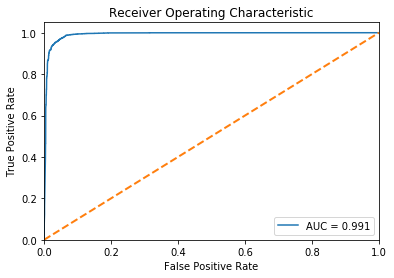

In [84]:
#Preparing ROC Curve for Random Forest

y_test.replace('Expert',1,inplace=True)
y_test.replace('Normal',0,inplace=True)
y_pred3 = pd.Series(y_pred)
y_pred3.replace('Expert',1,inplace=True)
y_pred3.replace('Normal',0,inplace=True)

# calculate the fpr and tpr for all thresholds of the classification
probs = rf.predict_proba(y_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc2 = metrics.auc(tpr, fpr)

# method I: plt
lw = 2
plt.title('Receiver Operating Characteristic')
plt.plot(tpr, fpr,label = 'AUC = %0.3f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h3><center><font color=DarkSlateBlue > Reviewing Features that most contributed to the Random Forest Model

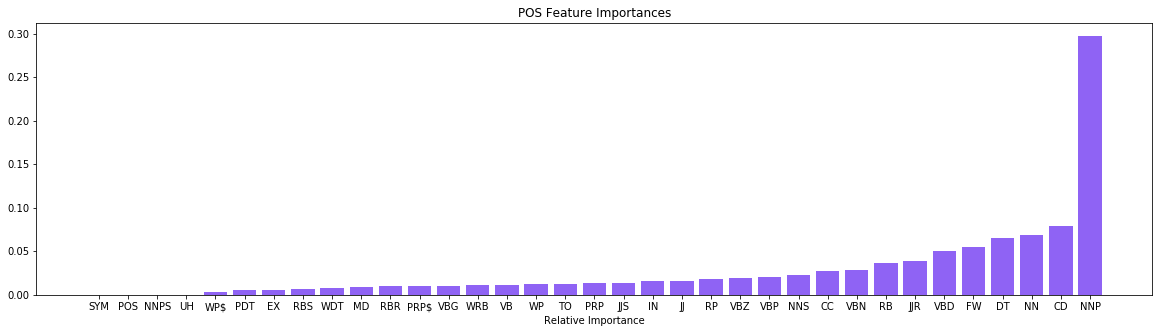

In [85]:
features = X_train.columns.values
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(20,5))
plt.title('POS Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='#8f63f4', align='center')
plt.xticks(range(len(indices)), features[indices],)
plt.xlabel('Relative Importance')

plt.show()

In [86]:
means = combine_new.groupby('Reviewer').mean()
means

,NNS,VBP,PRP,DT,NN,RB,VBZ,IN,JJ,WRB,PRP$,CC,CD,MD,VB,TO,VBG,JJS,VBD,VBN,WP,RBR,JJR,WDT,EX,RP,PDT,RBS,FW,NNPS,UH,NNP,WP$,POS,SYM,WC
Reviewer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Expert,0.049386,0.029720,0.022290,0.070440,0.307469,0.039539,0.032591,0.089187,0.101259,0.003103,0.013126,0.023254,0.024245,0.006329,0.028563,0.018459,0.018093,0.002444,0.016575,0.019542,0.003577,0.001755,0.002621,0.003884,0.001183,0.00309,0.000775,0.000576,0.018892,0.000007,0.000024,0.032580,0.000149,4.975977e-06,4.509875e-07,868.765667
Normal,0.047536,0.022637,0.030256,0.090747,0.373760,0.055111,0.026344,0.075582,0.082126,0.003952,0.011678,0.031082,0.010384,0.007861,0.029320,0.015703,0.017672,0.003999,0.029750,0.015180,0.003701,0.001842,0.003014,0.003408,0.001565,0.00313,0.001489,0.000711,0.000239,0.000007,0.000059,0.000114,0.000039,3.827689e-07,0.000000e+00,104.160200


<left><font color=DarkSlateBlue > Based on above observation we can deduce that Expert tends to use Proper Noun (NNP),Cardinal Numeral (CD), Noun(NN) more frequently than Normal user. 

<h2><center><font color=DarkSlateBlue > Accuracy Improvement - Combining POS and CountVectorizer Dataset to run SVM

In [ ]:
#Tokenize, create Part of Speech Tags and combine them
combine['pos text'] =  [nltk.word_tokenize(i)for i in combine['Review']] 
combine['pos'] =  [nltk.pos_tag(i)for i in combine['pos text']]   
combine['pos_counter'] = [Counter( tag for word ,  tag in i) for i in combine['pos']] 

In [ ]:
combine['text length'] = combine['Review'].apply(lambda x: len(x) - x.count(" "))

In [ ]:
pos_councter_df = combine['pos_counter'].apply(pd.Series)
pos_councter_df = pos_councter_df.fillna(0)
combine = pd.concat([combine, pos_councter_df], axis=1)
cols = combine.columns.tolist()

Combining Data - POS Model + Count Vectorizer

In [ ]:
#Tokenize, create Part of Speech Tags and combine them
combine['pos text'] =  [nltk.word_tokenize(i)for i in combine['Review_Short']] 
combine['pos'] =  [nltk.pos_tag(i)for i in combine['pos text']]   
combine['pos_counter'] = [Counter( tag for word ,  tag in i) for i in combine['pos']] 
    

In [ ]:
#Getting count columns  for  each Part of Speech Tag
pos_councter_df = combine['pos_counter'].apply(pd.Series)
pos_councter_df = pos_councter_df.fillna(0)

In [ ]:
pos_councter_df = pos_councter_df.drop([ "''", '$'],axis=1)

In [ ]:
pos_councter_df.columns

In [ ]:
#Running Random forest model
X_train, y_train, X_test,y_test = train_test_split(z,label,test_size = 0.2,random_state=52)
rf = RandomForestClassifier(n_estimators=100,max_depth=20,n_jobs=-1)
rf_model = rf.fit(X_train,X_test)
y_pred3 =rf_model.predict(y_train)